In [1]:
import os
import sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

/Users/andrejizvarin/Documents/___project/emotion_recognition/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Изменение текущей рабочей директории
os.chdir("../")
%pwd

'/Users/andrejizvarin/Documents/___project/emotion_recognition'

In [3]:
# Добавление пути к каталогу src в системные пути, чтобы Python мог найти модуль data_loader
module_path = "src"
if module_path not in sys.path:
    sys.path.append(module_path)

from data_loader import DataLoader

In [4]:
data_path = "data"
data_loader = DataLoader(data_path)

In [5]:
# Функция для загрузки и предобработки данных
def prepare_dataset(batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_loader.load_dataset(batch_size=batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 9), dtype=tf.float32),
        ),
    )
    # Кэширование данных после загрузки для ускорения доступа
    dataset = dataset.cache()
    # Перемешивание данных
    dataset = dataset.shuffle(buffer_size=1000)
    # Параллельная обработка и префетчинг
    dataset = dataset.map(
        lambda x, y: (tf.image.per_image_standardization(x), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Повторно начинать выдачу данных с начала, когда генератор достигнет конца набора данных
    dataset = dataset.repeat()

    return dataset


# Создание обучающего и валидационного наборов
train_dataset = prepare_dataset(batch_size=32)

In [6]:
def create_mobilenetv3_model(num_classes=9, fine_tune=False):
    base_model = MobileNetV3Large(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )
    if fine_tune:
        # Разморозка всех слоев
        for layer in base_model.layers:
            layer.trainable = True
    else:
        # Заморозка базовой модели
        base_model.trainable = False

    # Добавление новых слоев
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)  # Слой Dropout для предотвращения переобучения
    outputs = Dense(num_classes, activation="softmax")(x)

    # Собираем полную модель
    model = Model(inputs=base_model.input, outputs=outputs)

    # Компилируем модель
    model.compile(
        optimizer=Adam(learning_rate=0.0001 if fine_tune else 0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


model = create_mobilenetv3_model()

In [7]:
# Количество образцов
num_train_samples = len(data_loader.labels_df)
num_val_samples = int(0.2 * num_train_samples)

batch_size = 32  # Размер пакета

steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size

history = model.fit(
    train_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=train_dataset,
    validation_steps=validation_steps,
)

Epoch 1/20


2024-05-01 03:33:49.144899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 76 of 1000
2024-05-01 03:33:59.182759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 149 of 1000
2024-05-01 03:34:09.268553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 229 of 1000
2024-05-01 03:34:29.126749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 362 of 1000
2024-05-01 03:34:49.175556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 518 of 1000
2024-05-01 03:35:09.141033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while):

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 463s 201ms/step - accuracy: 0.1998 - loss: 2.1435 - val_accuracy: 0.1595 - val_loss: 2.1571
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 305s 195ms/step - accuracy: 0.2177 - loss: 2.0585 - val_accuracy: 0.2065 - val_loss: 2.0735
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 293s 188ms/step - accuracy: 0.2393 - loss: 2.0185 - val_accuracy: 0.2317 - val_loss: 2.0365
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 294s 188ms/step - accuracy: 0.2553 - loss: 1.9892 - val_accuracy: 0.2683 - val_loss: 1.9866
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 292s 187ms/step - accuracy: 0.2530 - loss: 1.9763 - val_accuracy: 0.2516 - val_loss: 1.9702
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 290s 185ms/step - accuracy: 0.2667 - loss: 1.9555 - val_accuracy: 0.2353 - val_loss: 2.0308
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 294s 188ms/step - accuracy: 0.2747 - loss: 1.9304 - val_accuracy: 0.2469 - val_loss: 1.9827
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 293s 188ms/step - accuracy: 0.2

In [8]:
# Оценка модели
val_loss, val_accuracy = model.evaluate(train_dataset, steps=50)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

# Сохранение модели
model.save("models/mobilenet_v3.h5")

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.2895 - loss: 1.8664


Validation Accuracy: 27.06%


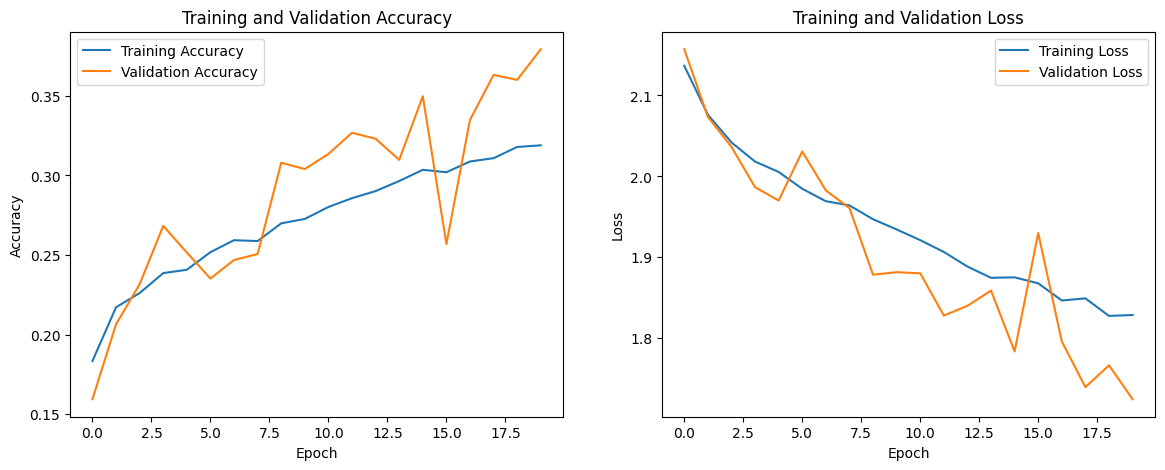

In [9]:
def plot_training_history(history):
    # График точности
    plt.figure(figsize=(14, 5))

    # Подграфик для точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Подграфик для потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


plot_training_history(history)